In [5]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import scipy 
from neurosim.models.ssr import StateSpaceRealization as SSR
import sys
import pdb

In [7]:
sys.path.append('../..')

In [8]:
from subspaces import SubspaceIdentification, factorize
from em import StableStateSpaceML

In [9]:
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [ ]:
# Demonstrate what closing the loop with this analysis looks like
# (0) Can one obtain the minimum phase model from a small state dimension?
# (1) Sweep through the state dimensions and fit SSID/StableML (and when feasible, VAR models). Use the fitted models to produce correlation sequences relevant
# for the control problem. Assess consistency with solution derived from the ground truth correltaions
# (2) Compare the LQGCA solutions compared with the ordinary optimal feedback control problem
# (3) Does underestimating the state dimension cause problems? 

In [27]:
# Specific observables:
# (1) Transmission zeros
# (4) Actuator mismatch

In [10]:
# (1) Finding transmission zeros
def transmission_zeros(A, B, C, D):
    # Form matrices for generalized eigenvalue problem
    try:
        BB = np.block([[np.eye(A.shape[0]), np.zeros(B.shape)], [np.zeros(C.shape), np.zeros(D.shape)]])
    except:
        pdb.set_trace()
    AA = np.block([[A, B], [C , D]])
    eig, _ = scipy.linalg.eig(AA,b=BB)
    return eig

In [11]:
def autocorrelation1(A, C, Q, R, S, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    # Construct Cbar from A, P, C, and S
    Cbar = C @ P @ A.T + S.T

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 


In [12]:
def autocorrelation2(A, C, Cbar, Q, R, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 

In [27]:
model_reps = 5
trajectory_reps = 1
state_dim = 40
obs_dim = 40

results_list = []

for i in range(model_reps):

    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
    while max(np.abs(np.linalg.eigvals(A))) > 0.99:
        A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

    #C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
    ssr = SSR(A=A, B = np.eye(A.shape[0]), C = np.eye(A.shape[0]))

    # Fit LQGCA and KCA (time reversed) to the true autocorrelations
    lqgca = LQGCA(T=3, d=2)
    lqgca.cross_covs = ssr.autocorrelation(5)
    # Fit 10 tries
    true_lqgca_coefs = []
    for _ in range(10):
        v, _ = lqgca._fit_projection()
        true_lqgca_coefs.append(v)
    # Reverse time KCA loadings
    kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
    kcamodel.cross_covs = ssr.autocorrelation(5)
    true_kcacoefs = []
    for _ in range(10):
        v, _ = kcamodel._fit_projection()
        true_kcacoefs.append(v)

    for j in range(trajectory_reps):
        y = ssr.trajectory(int(1e4))
        # First, fit SSID and state space models where we tune the model order from too low, right, to too high
        for model_order in [20, 25, 30, 35, 40]:
            print('Fitting SSID')
            ssid = SubspaceIdentification()
            ssid.identify(y, order=model_order)
            A, C, Cbar, L0, Q, R, S = ssid.identify(y, order=model_order)        
            Sigma0 = scipy.linalg.solve_discrete_lyapunov(A, Q)

            # Calculate system zeros - experiment with the factorize function and also sqrt factorizing R and Q
            B1, D1 = factorize(A, C, Cbar, L0)
            eB, uB = scipy.linalg.eig(Q)
            eD, uD = scipy.linalg.eig(R)

            # Rectify spectrum
            eB[np.abs(eB) < 1e-8] = 0
            eD[np.abs(eD) < 1e-8] = 0

            B2 = uB @ np.diag(np.sqrt(eB))
            D2 = uD @ np.diag(np.sqrt(eD))

            z1 = transmission_zeros(A, B1, C, D1)
            # z2 = transmission_zeros(A, B2, C, D2)

            ssid_cross_covs = autocorrelation2(A, C, Cbar, Q, R, 5)

            # LQGCA loadings
            lqgca = LQGCA(T=3, d=2)
            lqgca.cross_covs = ssid_cross_covs
            # Fit 10 tries
            lqgca_coefs = []
            for _ in range(10):
                v, _ = lqgca._fit_projection()
                lqgca_coefs.append(v)
            # Reverse time KCA loadings
            kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
            kcamodel.cross_covs = ssid_cross_covs
            kcacoefs = []
            for _ in range(10):
                v, _ = kcamodel._fit_projection()
                kcacoefs.append(v)


            result = {}
            result['model_rep'] = 1
            result['trajectory_rep'] = 1
            result['model_order'] = model_order
            result['true_lqgca'] = true_lqgca_coefs
            result['true_kca'] = true_kcacoefs
            result['z1'] = z1
            result['lqgca_ssid'] = lqgca_coefs
            result['kca_ssid'] = kcacoefs


            print('Fitting SSML')
            ssm = StableStateSpaceML(max_iter=5, init_strategy='manual')
            try:
                ssm.fit(y, state_dim=model_order, Ainit=A, Cinit=C, Qinit=Q, Rinit=R,
                        x0 = np.zeros(A.shape[0]), Sigma0 = Sigma0)
            except:
                result['lgqca_ssl'] = np.nan
                result['kca_ssl'] = np.nan
                results_list.append(result)
                continue

            ccm_ml = autocorrelation1(ssm.A, ssm.C, np.eye(ssm.A.shape[0]), ssm.R, np.zeros((ssm.A.shape[0], ssm.C.shape[0])), 5)

            # LQGCA loadings
            lqgca = LQGCA(T=3, d=2)
            lqgca.cross_covs = ccm_ml
            # Fit 10 tries
            lqgca_coefs = []
            for _ in range(10):
                v, _ = lqgca._fit_projection()
                lqgca_coefs.append(v)
            # Reverse time KCA loadings
            kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
            kcamodel.cross_covs = ccm_ml
            kcacoefs = []
            for _ in range(10):
                v, _ = kcamodel._fit_projection()
                kcacoefs.append(v)

            result['lqgca_ssl'] = lqgca_coefs
            result['kca_ssl'] = kcacoefs

            results_list.append(result)


Fitting SSID
Fitting SSML
E step: 9.753644
M step: 0.598059
Fitting SSID
Fitting SSML
E step: 11.911794
M step: 0.462713


In [16]:
# Tasks for tomorrow
# Produce plots for this guy, its VAR equivalent, and similarly the VAR equivalent for the other guy
# However, start with runningb ARMA state space on a VAR fit
# To do control theoretic analysis on non-square models, may need to "ignore" the D matrix
# Produce conceptual figure about the role of predictor spaces
# Time permitting, outline polar decomposition stuff (unlikely)

In [14]:
from pyuoi.linear_model.var import VAR
from neurosim.models.var import VAR as VARss, form_companion

In [15]:
model_reps = 5
trajectory_reps = 1
state_dim = 40
obs_dim = 40

results_list = []

for i in range(model_reps):

    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
    while max(np.abs(np.linalg.eigvals(A))) > 0.99:
        A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

    #C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
    ssr = SSR(A=A, B = np.eye(A.shape[0]), C = np.eye(A.shape[0]))

    # Fit LQGCA and KCA (time reversed) to the true autocorrelations
    lqgca = LQGCA(T=3, d=2)
    lqgca.cross_covs = ssr.autocorrelation(5)
    # Fit 10 tries
    true_lqgca_coefs = []
    for _ in range(10):
        v, _ = lqgca._fit_projection()
        true_lqgca_coefs.append(v)
    # Reverse time KCA loadings
    kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
    kcamodel.cross_covs = ssr.autocorrelation(5)
    true_kcacoefs = []
    for _ in range(10):
        v, _ = kcamodel._fit_projection()
        true_kcacoefs.append(v)

    for j in range(trajectory_reps):
        y = ssr.trajectory(int(1e4))
        # First, fit SSID and state space models where we tune the model order from too low, right, to too high
        for var_order in [1, 2, 3, 4]:
            varmodel1 =  VAR(order=var_order, estimator='ols')
            varmodel1.fit(y)
            var_ssm = VARss(varmodel1.coef_)

            lqgca = LQGCA(T=3, d=2)
            lqgca.cross_covs = var_ssm.autocorrelation(5)
            # Fit 10 tries
            lqgca_coefs_ols = []
            for _ in range(10):
                v, _ = lqgca._fit_projection()
                lqgca_coefs_ols.append(v)
            # Reverse time KCA loadings
            kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
            kcamodel.cross_covs = var_ssm.autocorrelation(5)
            kcacoefs_ols = []
            for _ in range(10):
                v, _ = kcamodel._fit_projection()
                kcacoefs_ols.append(v)

            varmodel2 = VAR(order=var_order, estimator='uoi', penalty='scad', fit_type='union_only')
            varmodel2.fit(y)
            var_ssm = VARss(varmodel2.coef_)

            lqgca = LQGCA(T=3, d=2)
            lqgca.cross_covs = var_ssm.autocorrelation(5)
            # Fit 10 tries
            lqgca_coefs_uoi = []
            for _ in range(10):
                v, _ = lqgca._fit_projection()
                lqgca_coefs_uoi.append(v)
            # Reverse time KCA loadings
            kcamodel = KCA(T=3, d=2, causal_weights=(0, 1))
            kcamodel.cross_covs = var_ssm.autocorrelation(5)
            kcacoefs_uoi = []
            for _ in range(10):
                v, _ = kcamodel._fit_projection()
                kcacoefs_uoi.append(v)

            result = {}
            result['model_rep'] = 1
            result['trajectory_rep'] = 1
            result['var_order'] = var_order
            result['true_lqgca'] = true_lqgca_coefs
            result['true_kca'] = true_kcacoefs
            result['lqgca_ols'] = lqgca_coefs_ols
            result['kca_ols'] = kcacoefs_ols
            result['lqgca_uoi'] = lqgca_coefs_uoi
            result['kca_uoi'] = kcacoefs_uoi

            results_list.append(result)


40it [00:00, 64.99it/s]
0it [00:00, ?it/s]

Training is over.


1it [00:05,  5.58s/it]

Training is over.


2it [00:10,  5.02s/it]

Training is over.


2it [00:14,  7.35s/it]


KeyboardInterrupt: 

### Plotting

In [30]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
from utils import apply_df_filters, calc_loadings

In [19]:
with open('actuator_identification_results.dat', 'rb') as f:
    r1 = pickle.load(f)
    r2 = pickle.load(f)

In [20]:
df1 = pd.DataFrame(r1)

In [21]:
df2 = pd.DataFrame(r2)

In [22]:
df1.keys()

Index(['model_rep', 'trajectory_rep', 'model_order', 'true_lqgca', 'true_kca',
       'z1', 'lqgca_ssid', 'kca_ssid', 'lqgca_ssl', 'kca_ssl'],
      dtype='object')

In [37]:
df2.keys()

Index(['model_rep', 'trajectory_rep', 'var_order', 'true_lqgca', 'true_kca',
       'lqgca_ols', 'kca_ols', 'lqgca_uoi', 'kca_uoi'],
      dtype='object')

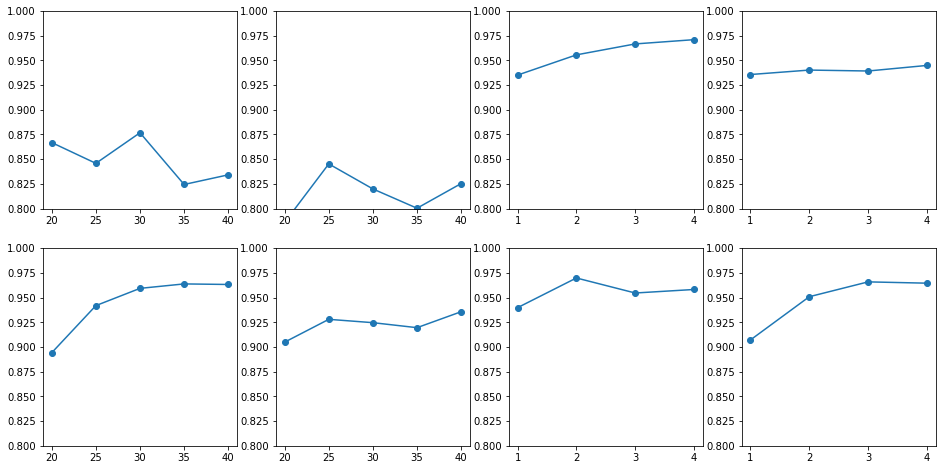

In [41]:
# Goal: plot the average maximumum spearman correlation between true LQGCA/Reverse time KCA loadings and those generated by the model as we increase the model order
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

####### LQGCA ############

## SSID
model_order = np.unique(df1['model_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df1, model_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_lqgca']
        ssid_lqgca = df_.iloc[0]['lqgca_ssid']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[0, 0].plot(model_order, model_order_spr, '-o')
ax[0, 0].set_title('SSID FCCA', fontsize=16)
ax[0, 0].set_ylabel('Leverage Score spearman-r', fontsize=16)
ax[0, 0].set_xlabel('McMillan Degree')

# Stable ML
model_order = np.unique(df1['model_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df1, model_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_lqgca']
        ssid_lqgca = df_.iloc[0]['lqgca_ssl']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[0, 1].plot(model_order, model_order_spr, '-o')
ax[0, 1].set_title('Stable SS ML FCCA', fontsize=16)
ax[0, 1].set_ylabel('Leverage Score spearman-r', fontsize=16)
ax[0, 1].set_xlabel('McMillan Degree')


# OLS VAR
model_order = np.unique(df2['var_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df2, var_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_lqgca']
        ssid_lqgca = df_.iloc[0]['lqgca_ols']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[0, 0].plot(model_order, model_order_spr, '-o')
ax[0, 0].set_title('VAR OLS FCCA', fontsize=16)
ax[0, 0].set_ylabel('Leverage Score spearman-r', fontsize=16)
ax[0, 0].set_xlabel('McMillan Degree')


# UoI VAR
model_order = np.unique(df2['var_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df2, var_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_lqgca']
        ssid_lqgca = df_.iloc[0]['lqgca_uoi']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[0, 3].plot(model_order, model_order_spr, '-o')

########## KCA #################

## SSID
model_order = np.unique(df1['model_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df1, model_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_kca']
        ssid_lqgca = df_.iloc[0]['kca_ssid']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[1, 0].plot(model_order, model_order_spr, '-o')
ax[1, 0].set_title('SSID')

# Stable ML
model_order = np.unique(df1['model_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df1, model_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_kca']
        ssid_lqgca = df_.iloc[0]['kca_ssl']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[1, 1].plot(model_order, model_order_spr, '-o')

# OLS VAR
model_order = np.unique(df2['var_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df2, var_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_kca']
        ssid_lqgca = df_.iloc[0]['kca_ols']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[1, 2].plot(model_order, model_order_spr, '-o')


# UoI VAR
model_order = np.unique(df2['var_order'].values)
model_order_spr = []
for order in model_order:
    df_ = apply_df_filters(df2, var_order=order)
    spr = []
    for model_rep in range(df_.shape[0]):
        true_lqgca = df_.iloc[0]['true_kca']
        ssid_lqgca = df_.iloc[0]['kca_uoi']
        
        spr.append(np.max([scipy.stats.spearmanr(calc_loadings(v1), calc_loadings(v2))[0] for v1 in true_lqgca for v2 in ssid_lqgca]))
    model_order_spr.append(np.nanmean(spr))
ax[1, 3].plot(model_order, model_order_spr, '-o')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):    
        ax[i, j].set_ylim([0.75, 1])

In [40]:
# Label, equalize axes